In [45]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pyvis.network import Network
import numpy as np


## Networkx

En esta actividad vamos a usar Networkx, una librería para gestionar grafos en python. Como toda librería de analítica, no reemplaza a un almacenamiento persistente, pero tiene la ventaja de poder levantarse rápidamente. 

Partamos por cargar un grafo. Esto esta sacado de la base de datos de cora (https://web.archive.org/web/20151007064508/http://linqs.cs.umd.edu/projects/projects/lbc/), que contiene papers, información de quién cita a qué, e información de las categorías de los papers. 

In [79]:
### Información de las aristas del grafo de cora

citas = pd.read_csv('cora/cora.cites',sep="\t",
    header=None,
    names=["target", "source"])

citas

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289
5427,853155,853118


In [29]:
### Metemos esto a networkx

G = nx.from_pandas_edgelist(citas, source="source", target="target",create_using=nx.DiGraph())

In [80]:
### Ahora levantamos la información de cada paper. Por ahora, solo vamos a usar el "subject"

### Información de los nodos de cora

column_names = ["paper_id"] + [f"word_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    'cora/cora.content', sep="\t", names=column_names,
)
subjects = papers[["paper_id","subject"]]

print(subjects.info())

print("Categorias: ")
print(subjects["subject"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2708 entries, 0 to 2707
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   paper_id  2708 non-null   int64 
 1   subject   2708 non-null   object
dtypes: int64(1), object(1)
memory usage: 42.4+ KB
None
Categorias: 
['Neural_Networks' 'Rule_Learning' 'Reinforcement_Learning'
 'Probabilistic_Methods' 'Theory' 'Genetic_Algorithms' 'Case_Based']


In [31]:
### Podemos agregar la información a nuestro grafo G de esta forma: 

subjects_dict = dict(zip(subjects['paper_id'], subjects['subject']))
nx.set_node_attributes(G, subjects_dict, 'subject')

Bueno, ahora tenemos nuestro grafo **G**. ¿Habrá alguna forma de visualizarlo? 
Dejamos dos códigos. Uno horrible pero que da una idea de como se ve todo, y otro para exportar el grafo a html.

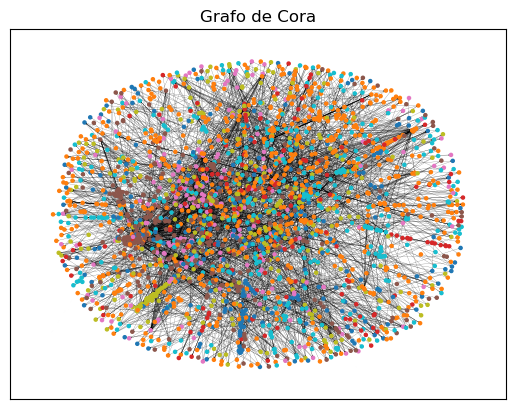

In [35]:
pos = nx.spring_layout(G)  # Layout algorithm for node positioning

# Assign a different color for each subject
unique_subjects = set(nx.get_node_attributes(G, 'subject').values())
cmap = cm.get_cmap('tab10', len(unique_subjects))
node_colors = [cmap(list(unique_subjects).index(G.nodes[node]['subject'])) for node in G.nodes]

# Draw the nodes with colors based on the 'category' attribute
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=5)

# Draw the edges
nx.draw_networkx_edges(G, pos, width=0.1, arrowsize=1,node_size=5)

# Draw node labels if desired
# nx.draw_networkx_labels(G, pos)

# Adjust the plot aesthetics
plt.title('Grafo de Cora')
#plt.axis('off')

# Display the graph
plt.show()

In [36]:
## Para exportar a html

nt = Network()
nt.from_nx(G)
nt.show("graph.html")

Recomendamos https://networkx.org/documentation/stable/tutorial.html para averiguar sobre primitivas básicas de Networkx. Pero por supuesto, soporta navegación. 

In [64]:
### Usamos sucessors o neighbours para ver los vecinos salientes de un nodo. 
### Para ver los atributos de un nodo, se los preguntamos a G.nodes. 

for n in G.successors(35):
    print(n)
    print(G.nodes[n])

82920
{'subject': 'Genetic_Algorithms', 'size': 10}
210871
{'subject': 'Genetic_Algorithms', 'size': 10}
210872
{'subject': 'Genetic_Algorithms', 'size': 10}


In [60]:
### Usamos predecessors para ver los vecinos salientes de un nodo. 
### Para ver los atributos de un nodo, se los preguntamos a G.nodes. 

for n in G.predecessors(35):
    print(n)
    print(G.nodes[n])

1033
{'subject': 'Genetic_Algorithms', 'size': 10}
103482
{'subject': 'Neural_Networks', 'size': 10}
103515
{'subject': 'Genetic_Algorithms', 'size': 10}
1050679
{'subject': 'Genetic_Algorithms', 'size': 10}
1103960
{'subject': 'Genetic_Algorithms', 'size': 10}
1103985
{'subject': 'Genetic_Algorithms', 'size': 10}
1109199
{'subject': 'Genetic_Algorithms', 'size': 10}
1112911
{'subject': 'Genetic_Algorithms', 'size': 10}
1113438
{'subject': 'Genetic_Algorithms', 'size': 10}
1113831
{'subject': 'Genetic_Algorithms', 'size': 10}
1114331
{'subject': 'Genetic_Algorithms', 'size': 10}
1117476
{'subject': 'Genetic_Algorithms', 'size': 10}
1119505
{'subject': 'Genetic_Algorithms', 'size': 10}
1119708
{'subject': 'Genetic_Algorithms', 'size': 10}
1120431
{'subject': 'Neural_Networks', 'size': 10}
1123756
{'subject': 'Genetic_Algorithms', 'size': 10}
1125386
{'subject': 'Theory', 'size': 10}
1127430
{'subject': 'Genetic_Algorithms', 'size': 10}
1127913
{'subject': 'Genetic_Algorithms', 'size': 1

# Analisis de Grafos: Centralidad

La centralidad de los nodos ha sido históricamente uno de los análisis más importantes en redes. Centralidad tiene que ver con qué nodo es más importante dentro de un grafo, y podemos entender la Centralidad como una función que toma un grafo y uno de sus nodos, y le asigna un valor numérico. Usualmente, mientras más alto el valor, más importante ese nodo. Vamos a ver tres métricas distintas de centralidad. 

### Degree centrality. 

Esta centralidad es simple. Como las conexiones muestran una importancia de los nodos, entonces los nodos con más aristas son los mas centrales. En el caso de los grafos dirigidos, usualmente se toma el grado de aristas entrantes: la cantidad de aristas que llegan a un nodo dado. 

In [185]:
### Ejercicio 1: Calcula los nodos más centrales de acuerdo al grado de aristas entrantes 
### (indegree centrality). 









### Pagerank Centrality. 

En su concepción original, pagerank trata de determinar la probabilidad que un caminante errático termine en ese nodo después de haber transitado un largo tiempo en el grafo. 

Supongamos que estamos en un nodo **n** que tiene tres aristas salientes. Nuestro caminante errático tendrá entonces $\frac{1}{3}$ de probabilidades de ir a cualquiera de esos tres nodos. 

La información de cada uno de estos nodos está en lo que conocemos como la *matriz estocástica* del grafo. En la matriz estocástica cada elemento de la matriz representa la probabilidad de moverse desde un nodo a otro nodo en un solo paso.

En una matriz estocástica, cada columna suma 1, lo que indica que la probabilidad total de transición desde un nodo dado es igual a 1. Esto refleja el hecho de que, en cada paso, el grafo debe moverse a un nodo adyacente, por lo que las probabilidades de transición deben sumar 1 para cumplir con esta propiedad.

In [98]:
### Partamos por la matriz de adyacencia
adj_matrix = nx.adjacency_matrix(G)

print(adj_matrix.shape)

#Columna correspondiente a paper numero 35: 

index = list(G.nodes()).index(35)
print("Num vecinos:" + str(adj_matrix[:,index].getnnz()))
print(adj_matrix[:,index])


(2708, 2708)
Num vecinos:166
  (0, 0)	1
  (2, 0)	1
  (3, 0)	1
  (4, 0)	1
  (5, 0)	1
  (6, 0)	1
  (7, 0)	1
  (8, 0)	1
  (9, 0)	1
  (10, 0)	1
  (11, 0)	1
  (12, 0)	1
  (13, 0)	1
  (14, 0)	1
  (15, 0)	1
  (16, 0)	1
  (17, 0)	1
  (18, 0)	1
  (19, 0)	1
  (20, 0)	1
  (21, 0)	1
  (22, 0)	1
  (23, 0)	1
  (24, 0)	1
  (25, 0)	1
  :	:
  (142, 0)	1
  (143, 0)	1
  (144, 0)	1
  (145, 0)	1
  (146, 0)	1
  (147, 0)	1
  (148, 0)	1
  (149, 0)	1
  (150, 0)	1
  (151, 0)	1
  (152, 0)	1
  (153, 0)	1
  (154, 0)	1
  (155, 0)	1
  (156, 0)	1
  (157, 0)	1
  (158, 0)	1
  (159, 0)	1
  (160, 0)	1
  (161, 0)	1
  (162, 0)	1
  (163, 0)	1
  (164, 0)	1
  (165, 0)	1
  (166, 0)	1


/var/folders/gf/12lsjk9d5mn0gdyhlk_xd0zm0000gn/T/ipykernel_11349/2994279940.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G)


In [87]:
### Puedes ver que estas entradas coinciden con los nodos salientes desde el nodo con id 35...
print(list(G.nodes())[0])
print(list(G.nodes())[2])
print(list(G.nodes())[166])

1033
103482
98698


In [189]:
column_sums = np.array(adj_matrix.sum(axis=0)).flatten()

# Replace zero column sums with 1 to avoid division by zero
column_sums[column_sums == 0] = 1

stoch_matrix = adj_matrix /column_sums

### la division genera representación densa, pero podemos ver aun la columna 1 con un 1/166
stoch_matrix[:,1]


matrix([[0.0060241],
        [0.       ],
        [0.0060241],
        ...,
        [0.       ],
        [0.       ],
        [0.       ]])

### Pagerank, inicialización. 

Al comienzo, el caminante tiene una probabilidad uniforme de estar en cada nodo. 

In [183]:
size = 2708
value = 1 / size

init_probs = np.full(size, value).reshape(-1, 1)
print(init_probs.shape)
init_probs


(2708, 1)


array([[0.00036928],
       [0.00036928],
       [0.00036928],
       ...,
       [0.00036928],
       [0.00036928],
       [0.00036928]])

### Pagerank, iteración. 

Si en un nodo el caminante tenia una probabilidad p, entonces esa probabilidad se distribuye entre los vecinos salientes. Al mismo tiempo, los vecinos entrantes me dan una nueva probabilidad. Despues de una iteración, el resultado corresponde al producto entre el vector de probabilidades y la matriz estocástica. 


In [206]:
new_values = np.dot(stoch_matrix,init_probs)
new_values

matrix([[7.68258118e-05],
        [1.06007387e-04],
        [2.22455553e-06],
        ...,
        [4.00049237e-04],
        [0.00000000e+00],
        [3.69276219e-04]])

### Pagerank, problemas! 

Pero qué pasa si hay nodos desconectados? Qué pasa si hay algún nodo que no tiene aristas que salen?

In [207]:
cuenta = 0
for i in new_values: 
    cuenta += i
cuenta

matrix([[0.57791728]])

### Pagerank, iteración (ahora si).

Normalmente en pagerank tenemos un *damping factor*. Esta es la proporción de la probabilidad sobre la cual el caminante se distirbuye a sus vecinos. El resto de la probabilidad se distribuye de forma equitativa sobre todos los nodos. 

In [204]:
damping_factor = 0.85 

new_values = damping_factor * np.dot(stoch_matrix, init_probs) + ((1 - damping_factor) / len(init_probs))

new_values = damping_factor * np.dot(stoch_matrix, new_values) + ((1 - damping_factor) / len(new_values))
new_values = damping_factor * np.dot(stoch_matrix, new_values) + ((1 - damping_factor) / len(new_values))

new_values


matrix([[6.82992917e-05],
        [7.49712141e-05],
        [5.57753215e-05],
        ...,
        [1.24270869e-04],
        [5.53914328e-05],
        [1.61021672e-04]])

In [ ]:
### Ejercicio 2

### Integra todo el codigo para realizar iteraciones de pagerank hasta que la diferencia de 
### los valores computados entre una iteración y otra no supere un cierto epsilon dado. 







### Betweeness Centrality. 

Esta es otra medida importante en grafos. Se trata de ver la proporción de caminos que pasan por un nodo en particular. Como la cantidad de caminos entre dos nodos son infinitas, usamos en vez la noción de camino más corto (que además resulta más fácil de calcular). 

Entonces, dados nodos $u$ y $v$ en un grafo $G$, usamos $C_{u,v}$ para escribir la cantidad de caminos mas cortos distintos entre $u$ y $v$ (entre dos nodos conectados siempre hay al menos uno de esos caminos). 

Para un nodo $n$, definitmos $\sigma_n(u,v)$ como $0$ si $u$ y $v$ no están conectados, o 
$\frac{C_{u,v}(n)}{C_{u,v}}$ si $u$ y $v$ están conectados, donde $C_{u,v}$ es la cantidad total de caminos mas cortos distintos entre $u$ y $v$ (entre dos nodos conectados siempre hay al menos uno de esos caminos), y $C_{u,v}(n)$ es la cantidad de esos caminos que ademas pasan por el nodo $n$. 

El valor de betweeness centrality de un nodo $n$ esta entonces dado por $\sum_{(u,v) \in G^2, n \neq u \neq v}\sigma_n(u,v)$.

In [ ]:
### Ejercicio 3

### Usa una primitiva de networkX para calcular betweenes centrality del grafo G.  


### Calculando betweenes centrality: algoritmo de Girvan-Newman

En clases discutiremos este algoritmo, que sirve para computar betweenes centrality de un nodo en particular (y por lo tanto, podemos iterar para computarlas todas), con una sola pasada por el grafo por cada nodo. 

No confundir con el algoritmo de Girvan-Newman para detectar comunidades!